# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a single image, and later apply the result to a video stream (really just a series of images). Check out the video clip "P0_example1.mp4" (also contained in this repository) to see what the output should look like. 

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to bring up an interactive matplotlib window displaying the image.

**Note:** you can zoom in and explore the image within the interactive matplotlib window.  If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the lines in the image, and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output image should look like this (more or less) after line detection </p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


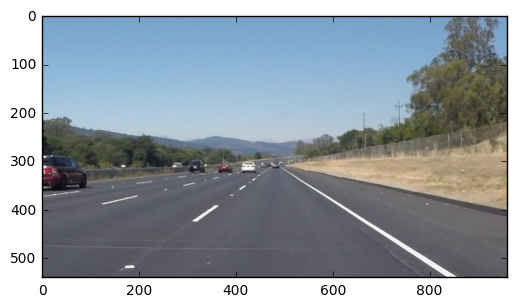

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

Below are a couple of utility functions you may find useful for developing/debugging your solution.

`run_pipeline`. Takes as input an image (`initial_image`), a list of a functions (`fns`), and the arguments to those functions (`fns_args`). `run_pipeline` then returns a list of images consisting of the initial image passed and the output image of each function.

`run_pipeline` **assumes each function takes in an image as it's first argument and returns an image as output**. The output image is then fed as input into the next function. Thus, the arguments for a function in `fns_args` should exclude the first argument.

`visualize_pipeline`. Takes in a list of images (`imgs`) as input, think of the output of `run_pipeline` and then plots the each image.

An example a couple of cells down will show how to use these functions.

In [3]:
def run_pipeline(initial_img, fns, fns_args):
    imgs = [initial_img]
    for fn, fn_args in zip(fns, fns_args):
        img = fn(imgs[-1], *fn_args)
        imgs.append(img)
        
    return imgs

def visualize_pipeline(imgs, fig):
    # plot imgs
    n = len(imgs)
    cols = 2
    rows = n // cols
    if n % cols != 0:
        rows += 1
    print('# rows = {}, # cols = {}'.format(rows, cols))
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='Greys_r')
        else:
            plt.imshow(img)

Here are some helpers functions to help get you started. They should look familiar from the lesson!

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((540, 960, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough transform. An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Below is an example of how you can test your pipeline on an image.

The function arguments are the ones used in the lesson.

The test images are in the `test_images` directory.

**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
ls test_images/

solidWhiteCurve.jpg     solidYellowCurve.jpg    solidYellowLeft.jpg
solidWhiteRight.jpg     solidYellowCurve2.jpg   whiteCarLaneSwitch.jpg


In [6]:
image = mpimg.imread('test_images/solidWhiteRight.jpg') # change this to test other images
fns = (grayscale, gaussian_noise, canny, region_of_interest, hough_lines, weighted_img)
fns_args = (
    (), 
    (5,),
    (50, 150),
    (np.array([[(120,539),(440, 317), (520, 317), (900,539)]], dtype=np.int32),), 
    (2, np.radians(1), 10, 100, 10),
    (np.copy(image),)
)

In [7]:
imgs = run_pipeline(image, fns, fns_args)

# rows = 4, # cols = 2


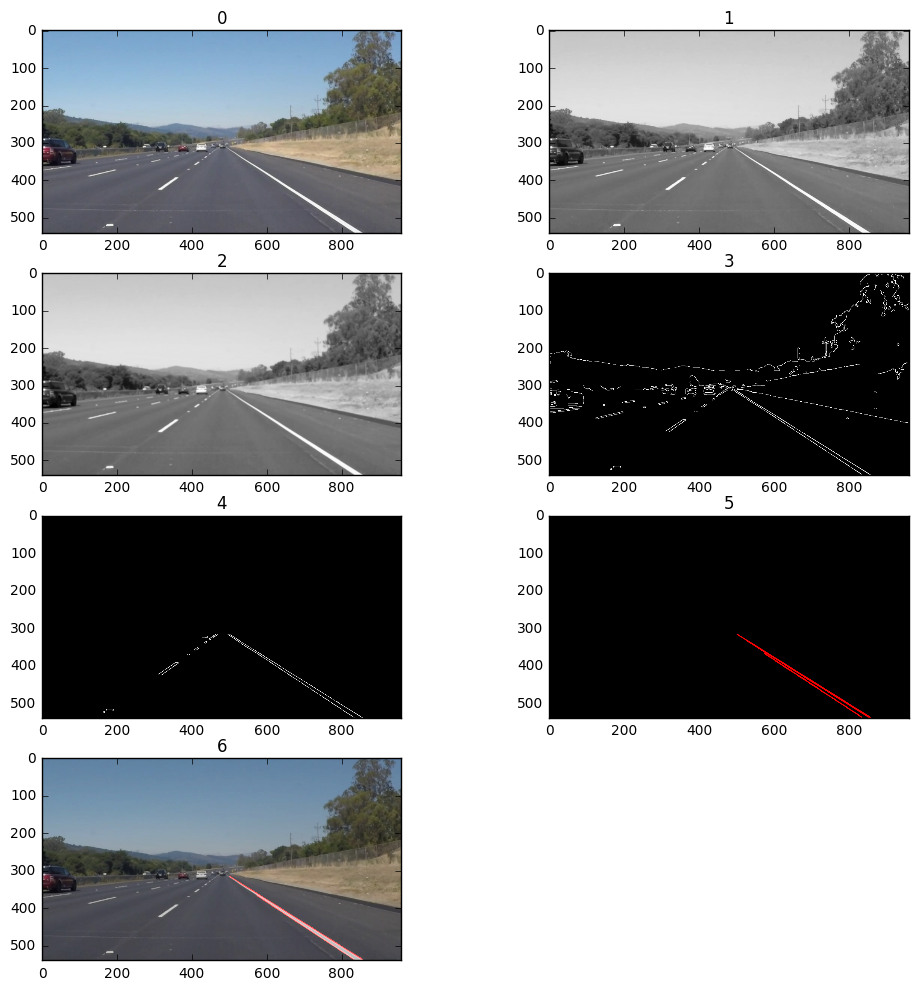

In [8]:
fig = plt.figure(figsize=(12,12), dpi=80)
visualize_pipeline(imgs, fig)

TODO: run the solution on all test_images and make copies in new directory (test_images_solution?).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # TODO: put your pipeline here, using run_pipeline or whatever else you come up with
    # you should return the final output (image with lines are drawn on lanes)
    fns = (grayscale, gaussian_noise, canny, region_of_interest, hough_lines, weighted_img)
    fns_args = (
        (), 
        (5,),
        (50, 150),
        (np.array([[(120,539),(440, 317), (520, 317), (900,539)]], dtype=np.int32),), 
        (2, np.radians(1), 10, 100, 10),
        (np.copy(image),)
    )
    imgs = run_pipeline(image, fns, fns_args)
    result = imgs[-1]
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 27.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.62 s, sys: 1.08 s, total: 4.69 s
Wall time: 9.27 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:33<00:00, 22.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 13.3 s, sys: 3.52 s, total: 16.8 s
Wall time: 34.9 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Submission

If you're satisfied with your video outputs it's time to submit!

TODO: submission process?